# Part 1: setup

#### Import libraries

In [7]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Import dataset

In [8]:
# url20 = "https://zenodo.org/records/8303397/files/full_data_20.csv?download=1"
# url60 = "https://zenodo.org/records/8303397/files/full_data_60.csv?download=1"
# url80 = "https://zenodo.org/records/8303397/files/full_data_80.csv?download=1"

# for when the website is down

url20 = "C:/Users\me59t\Downloads/3401 final/full_data_20.csv"
url60 = "C:/Users\me59t\Downloads/3401 final/full_data_60.csv"
url80 = "C:/Users\me59t\Downloads/3401 final/full_data_80.csv"

gamesAt20 = pd.read_csv(url20 , sep=',')
gamesAt60 = pd.read_csv(url60 , sep=',')
gamesAt80 = pd.read_csv(url80 , sep=',')

gamesAt20_no_clean = gamesAt20.copy()

backup20 = gamesAt20.copy()
backup60 = gamesAt60.copy()
backup80 = gamesAt80.copy()

#### reset data

In [9]:
# reset the dataset using backup

gamesAt20 = backup20.copy()
gamesAt60 = backup60.copy()
gamesAt80 = backup80.copy()
gamesAt20_no_clean = gamesAt20.copy()

#### Check for empty cells

In [10]:
gamesAt20.isna().sum()

Unnamed: 0                 0
matchID                    0
fullTimeMS                 0
timePercent                0
blueChampionKill           0
blueFirstBlood             0
blueDragonKill             0
blueDragonHextechKill      0
blueDragonChemtechKill     0
blueDragonFireKill         0
blueDragonAirKill          0
blueDragonEarthKill        0
blueDragonWaterKill        0
blueDragonElderKill        0
blueRiftHeraldKill         0
blueBaronKill              0
blueTowerKill              0
blueInhibitorKill          0
blueTotalGold              0
blueMinionsKilled          0
blueJungleMinionsKilled    0
blueAvgPlayerLevel         0
blueWin                    0
redChampionKill            0
redFirstBlood              0
redDragonKill              0
redDragonHextechKill       0
redDragonChemtechKill      0
redDragonFireKill          0
redDragonAirKill           0
redDragonEarthKill         0
redDragonWaterKill         0
redDragonElderKill         0
redRiftHeraldKill          0
redBaronKill  

In [11]:
(gamesAt20.values == '?').sum()

0

# Part 2: Clean the data

### Unused data
There are 2 features we can remove easily. The features are matchID and Unnamed.
We believe that Unnamed is a index counter, matchID is self explanatory.

In [12]:
gamesAt20.drop(labels=['Unnamed: 0' , 'matchID'] , axis=1 , inplace=True)
gamesAt60.drop(labels=['Unnamed: 0' , 'matchID'] , axis=1 , inplace=True)
gamesAt80.drop(labels=['Unnamed: 0' , 'matchID'] , axis=1 , inplace=True)
gamesAt20_no_clean.drop(labels=['Unnamed: 0' , 'matchID'] , axis=1 , inplace=True)

### Redundant data
Boolean columns like red/blue first blood and red/blue win are boolean and redundant, if one is true for red then it must be false for blue.
Moving forward we will drop red team boolean variables

In [13]:
gamesAt20['blueFirstBlood'] = gamesAt20['blueFirstBlood'].astype(int)
gamesAt20['blueWin'] = gamesAt20['blueWin'].astype(int)
gamesAt20.drop(labels=['redFirstBlood' , 'redWin'] , axis=1 , inplace=True)

gamesAt60['blueFirstBlood'] = gamesAt60['blueFirstBlood'].astype(int)
gamesAt60['blueWin'] = gamesAt60['blueWin'].astype(int)
gamesAt60.drop(labels=['redFirstBlood' , 'redWin'] , axis=1 , inplace=True)

gamesAt80['blueFirstBlood'] = gamesAt80['blueFirstBlood'].astype(int)
gamesAt80['blueWin'] = gamesAt80['blueWin'].astype(int)
gamesAt80.drop(labels=['redFirstBlood' , 'redWin'] , axis=1 , inplace=True)

### Extreme edge cases  

Furthermore since we are only at 20% of the game it is nearly impossible that inhibitors and towers have been destroyed, therefore we can safely remove them.
More features we can safely remove are baron kills and elder kills since baron spawns at 20 minutes, and the elder dragon spawns 5 minutes after one team has claimed 4 dragons, and each dragon is on a 5 minute respawn timer. This means that at a minimum it takes 25 minutes for elder to spawn. For these values to be greater than 0 that means the game must last for over 100 minutes, and since the average game time is 25-45 minutes the 100 minute+ game is a clear outlier that we can discard. Further into the game these metrics become more important so we will leave them in for data at longer timestamps.

In [14]:
gamesAt20.drop(labels=['blueBaronKill' , 'redBaronKill' , 'blueTowerKill' , 'redTowerKill' , 'blueDragonElderKill' , 'redDragonElderKill' , 'blueInhibitorKill' , 'redInhibitorKill'] , axis=1 , inplace=True)

### Inting, remakes, and FF

There are cases where a player may lave left the game early and the game can be "remade" or FF(forfeited) early, these games still have a win/loss outcome but we need to remove them since nothing actually happened in the game. To predict the outcome of these games is outside of the scope of this project.

There are cases where one or more players may be intentionally losing or a team may have just given up resulting in a FF, these games obviously need to be removed. This dataset lacks the features to properly detect inting but we can remove the games that are forfeited to remove enough of them.

To determine remade games we can simply compare the gold of each team, if they are the same then the game is remade. We will instead use a time cutoff since that will encompass the games with equal gold

In [15]:
# this is what we would have done to remove games that were known to be remakes
# gamesAt20.drop(gamesAt20[gamesAt20['blueTotalGold'] == gamesAt20['redTotalGold']].index , inplace=True)


To determine forfeited games we can cutoff all games that run for less than 17 minutes, 15 minutes is when the regular FF vote opens and we have 2 minute to allow for players to vote to end the game.
Let's look at a graph of the frequency of how long a game lasts. (this graph is identical across all our datasets)

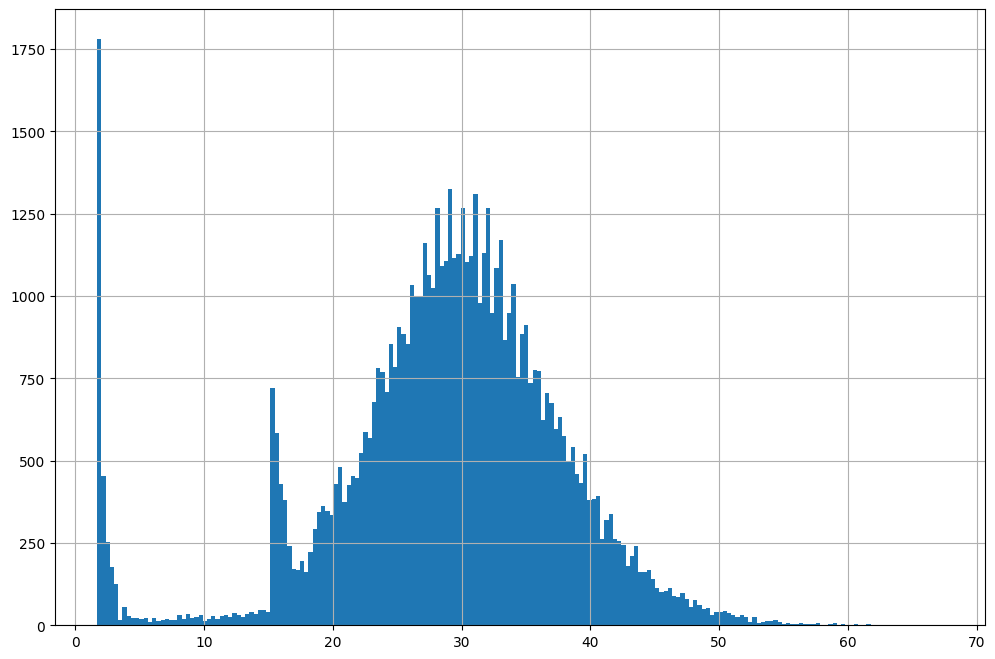

In [16]:
# add a column for the game time in minutes (for easier analysis)

gamesAt20['fullTimeMin'] = gamesAt20['fullTimeMS'] / 60000

# show the distribution of the game time
# this graph is will be the same across all our datasets

gamesAt20['fullTimeMin'].hist(bins = 200 , figsize=(12 , 8))
plt.show()

Notice there are two massive spikes from the distribution, the first one occurs before 5 minutes, these games are all remake. The second massive spike occurs just after 15 minutes, this is when the regular FF vote opens and games are forfeited, the games inbetween these two spikes are early FF votes. From this we can conclude every game before 17 minutes can be safely ignored.

In [17]:
gamesAt20.drop(gamesAt20[gamesAt20['fullTimeMS'] < 1020000].index , inplace=True)
gamesAt60.drop(gamesAt60[gamesAt60['fullTimeMS'] < 1020000].index , inplace=True)
gamesAt80.drop(gamesAt80[gamesAt80['fullTimeMS'] < 1020000].index , inplace=True)

Now we can see that our game lengths match up better with what is expected

In [18]:
gamesAt20['timePercent'].describe()

count    58344.000000
mean         5.674979
std          1.377235
min          3.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         13.000000
Name: timePercent, dtype: float64

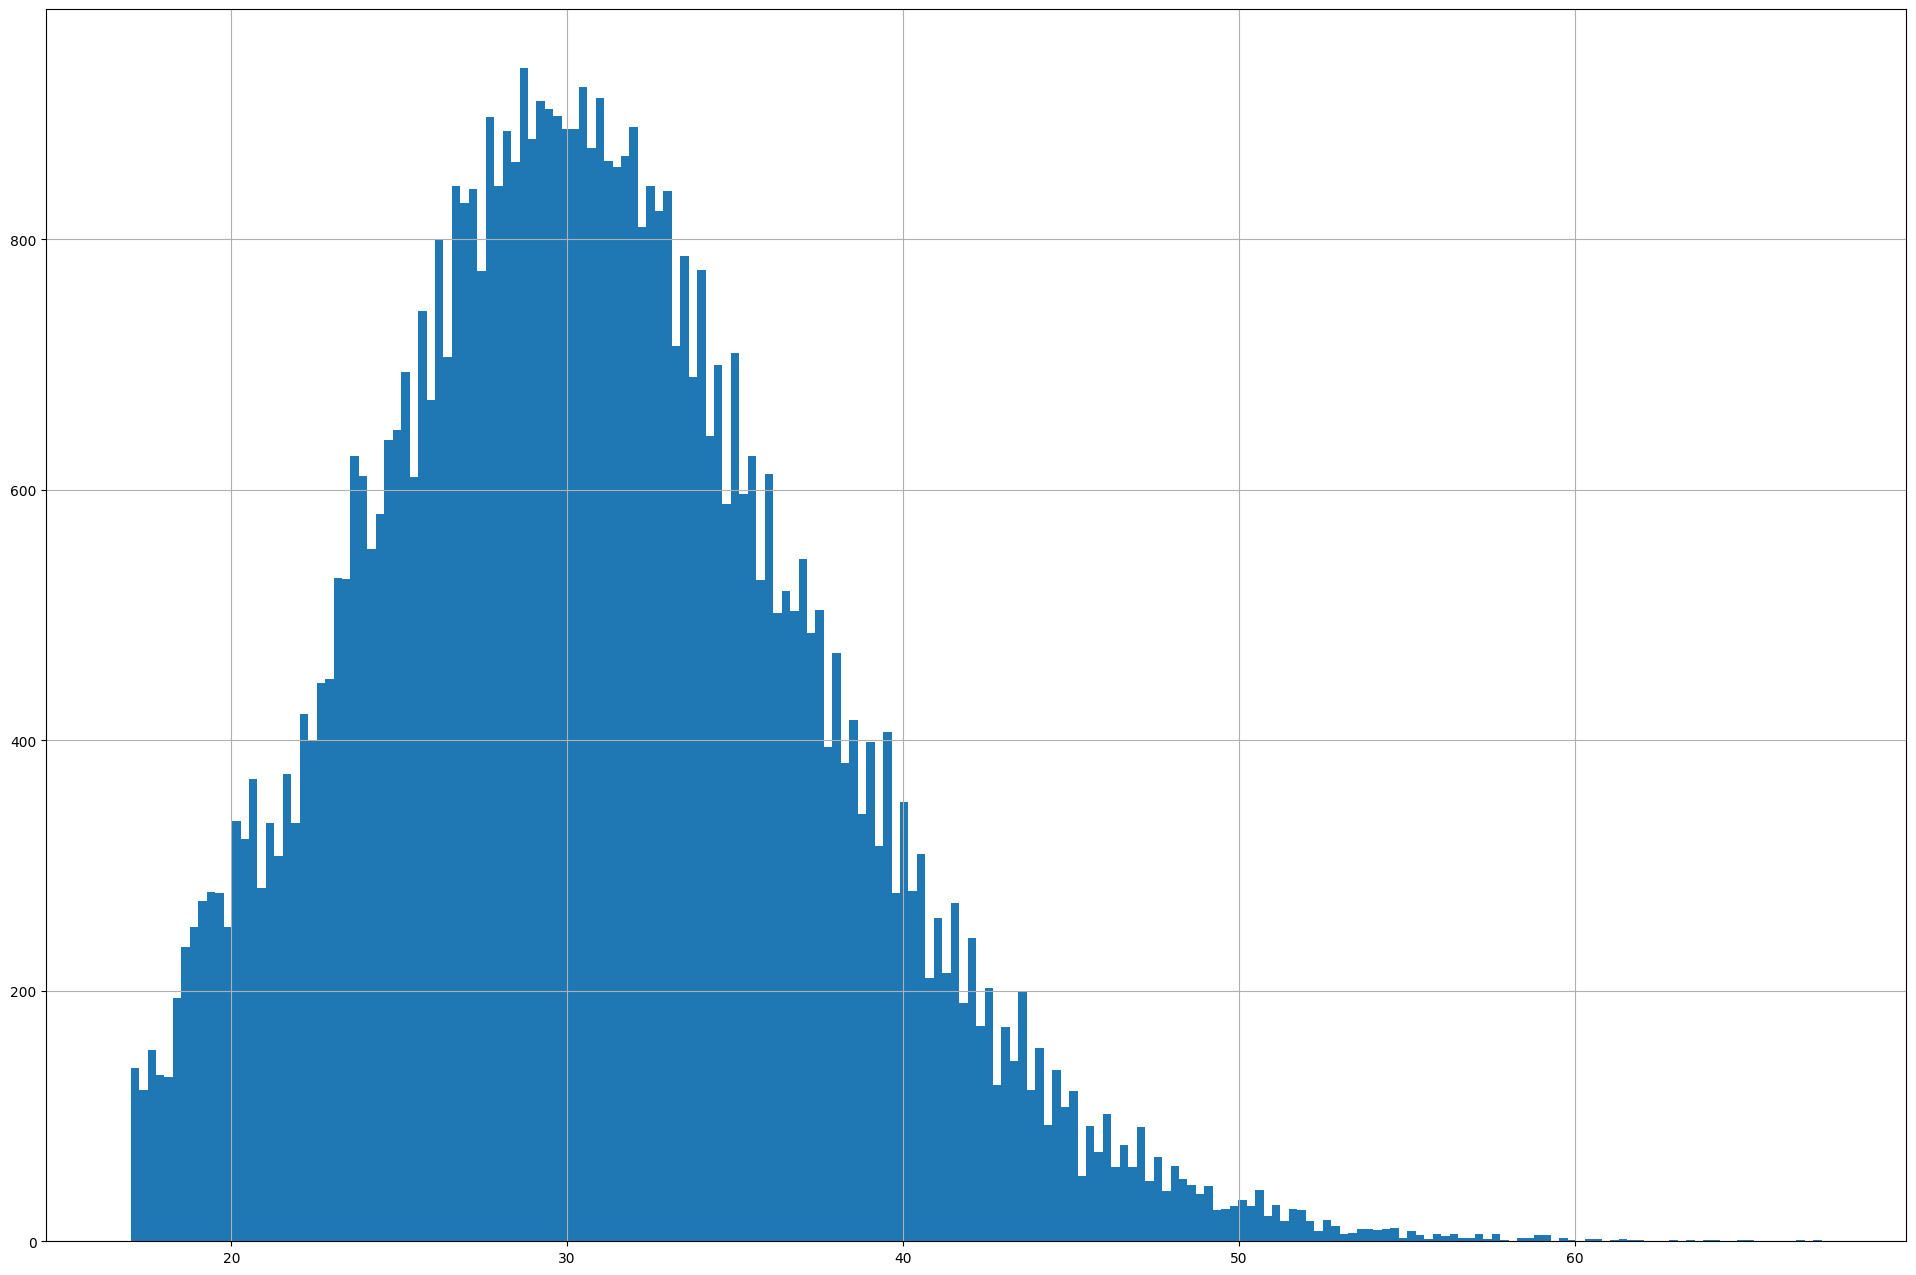

In [19]:
# this graph will be the same across all our datasets

gamesAt20['fullTimeMin'].hist(bins = 200 , figsize=(24 , 16))
plt.show()

### Refined graphs

These graphs are much better, however some values are stull bound at either 1 or 0, most are regarding neutral objectives. At this point in the game it is highly unlikely that any neutral objective will have been claimed so we should be able to safely remove these data points, but we will determine how much the actually matter first.

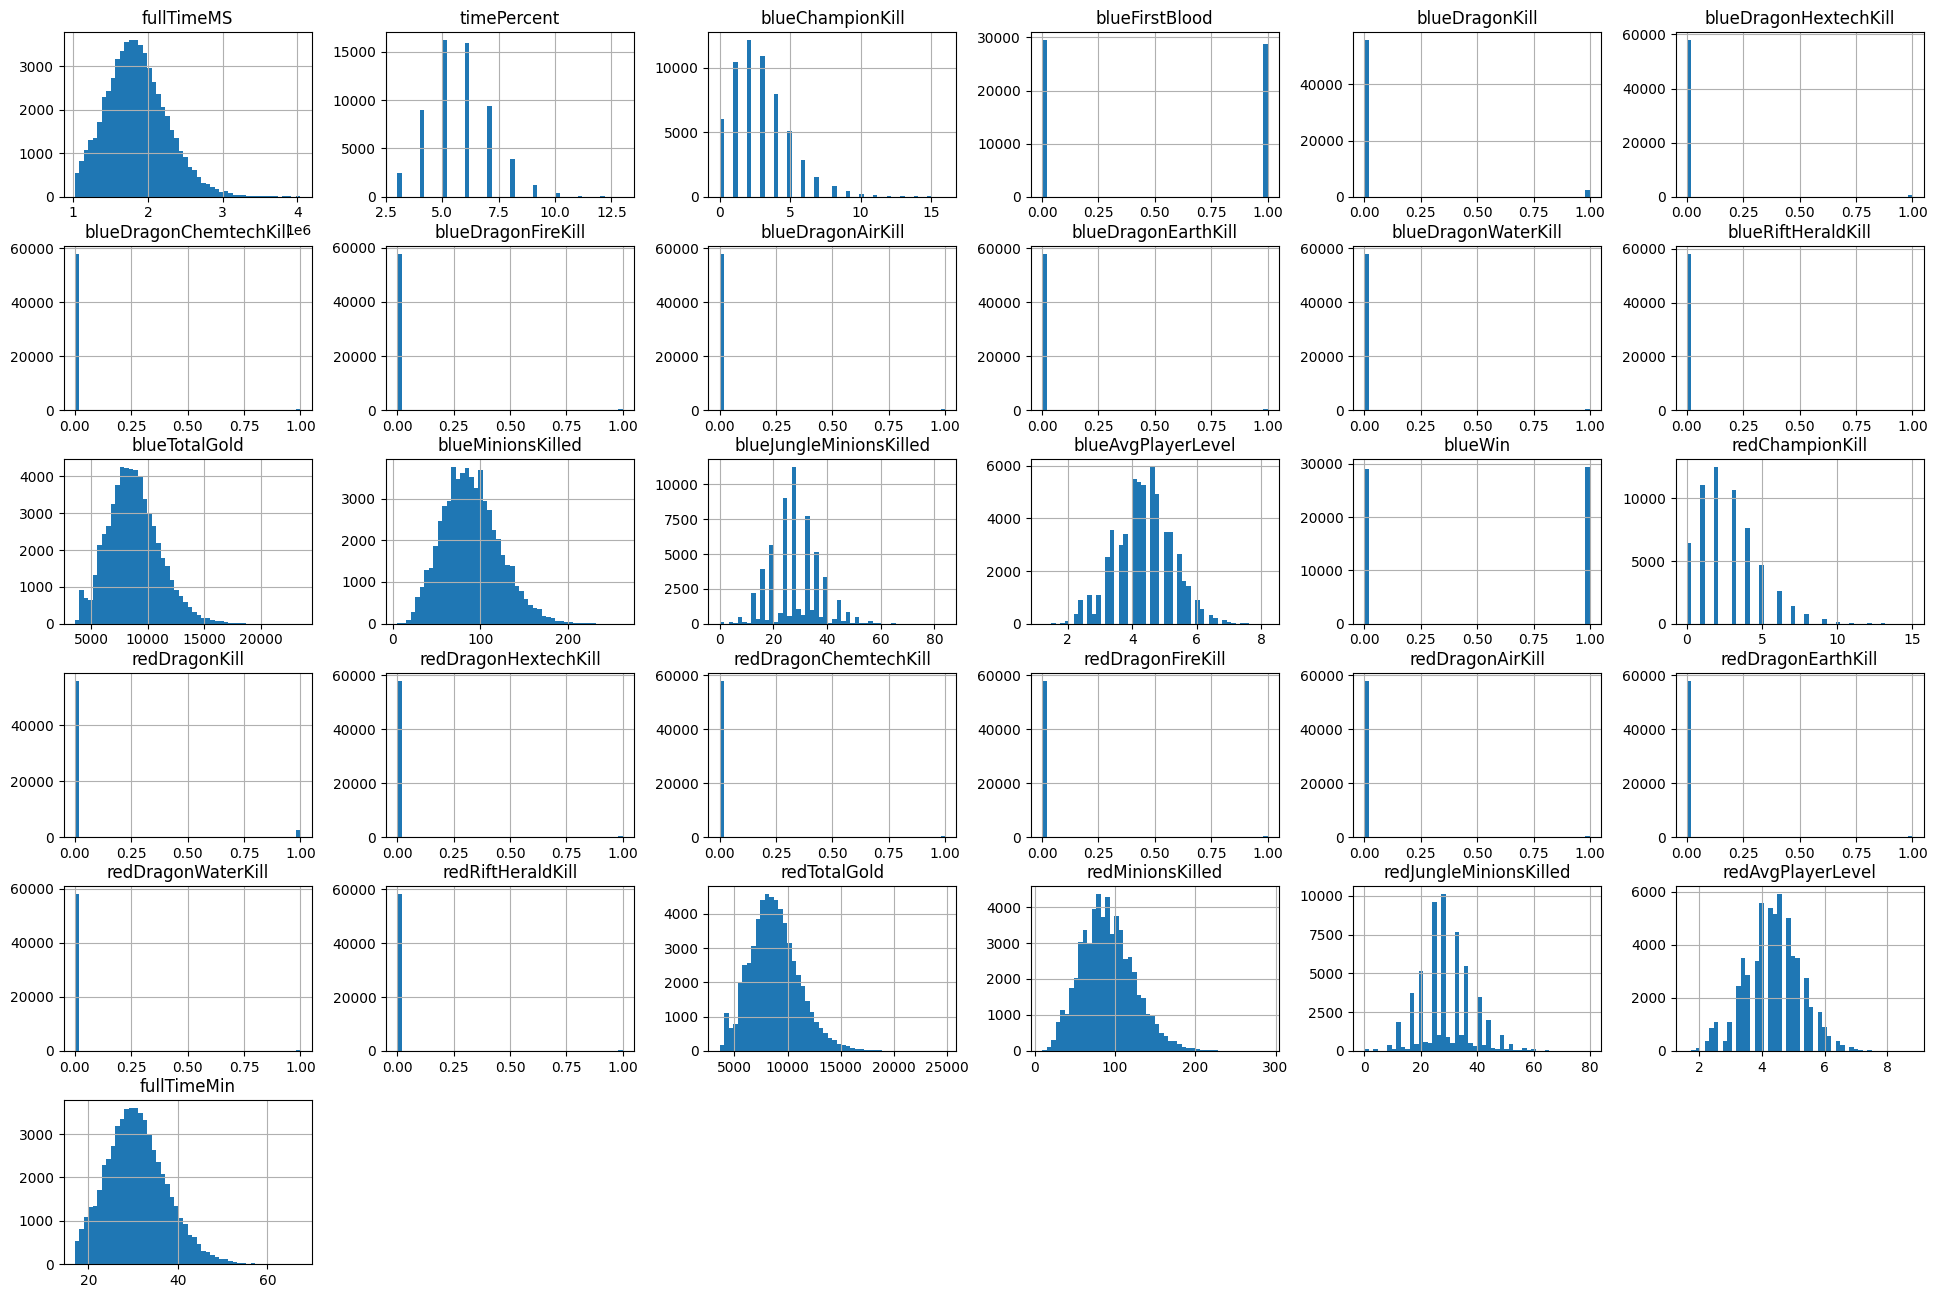

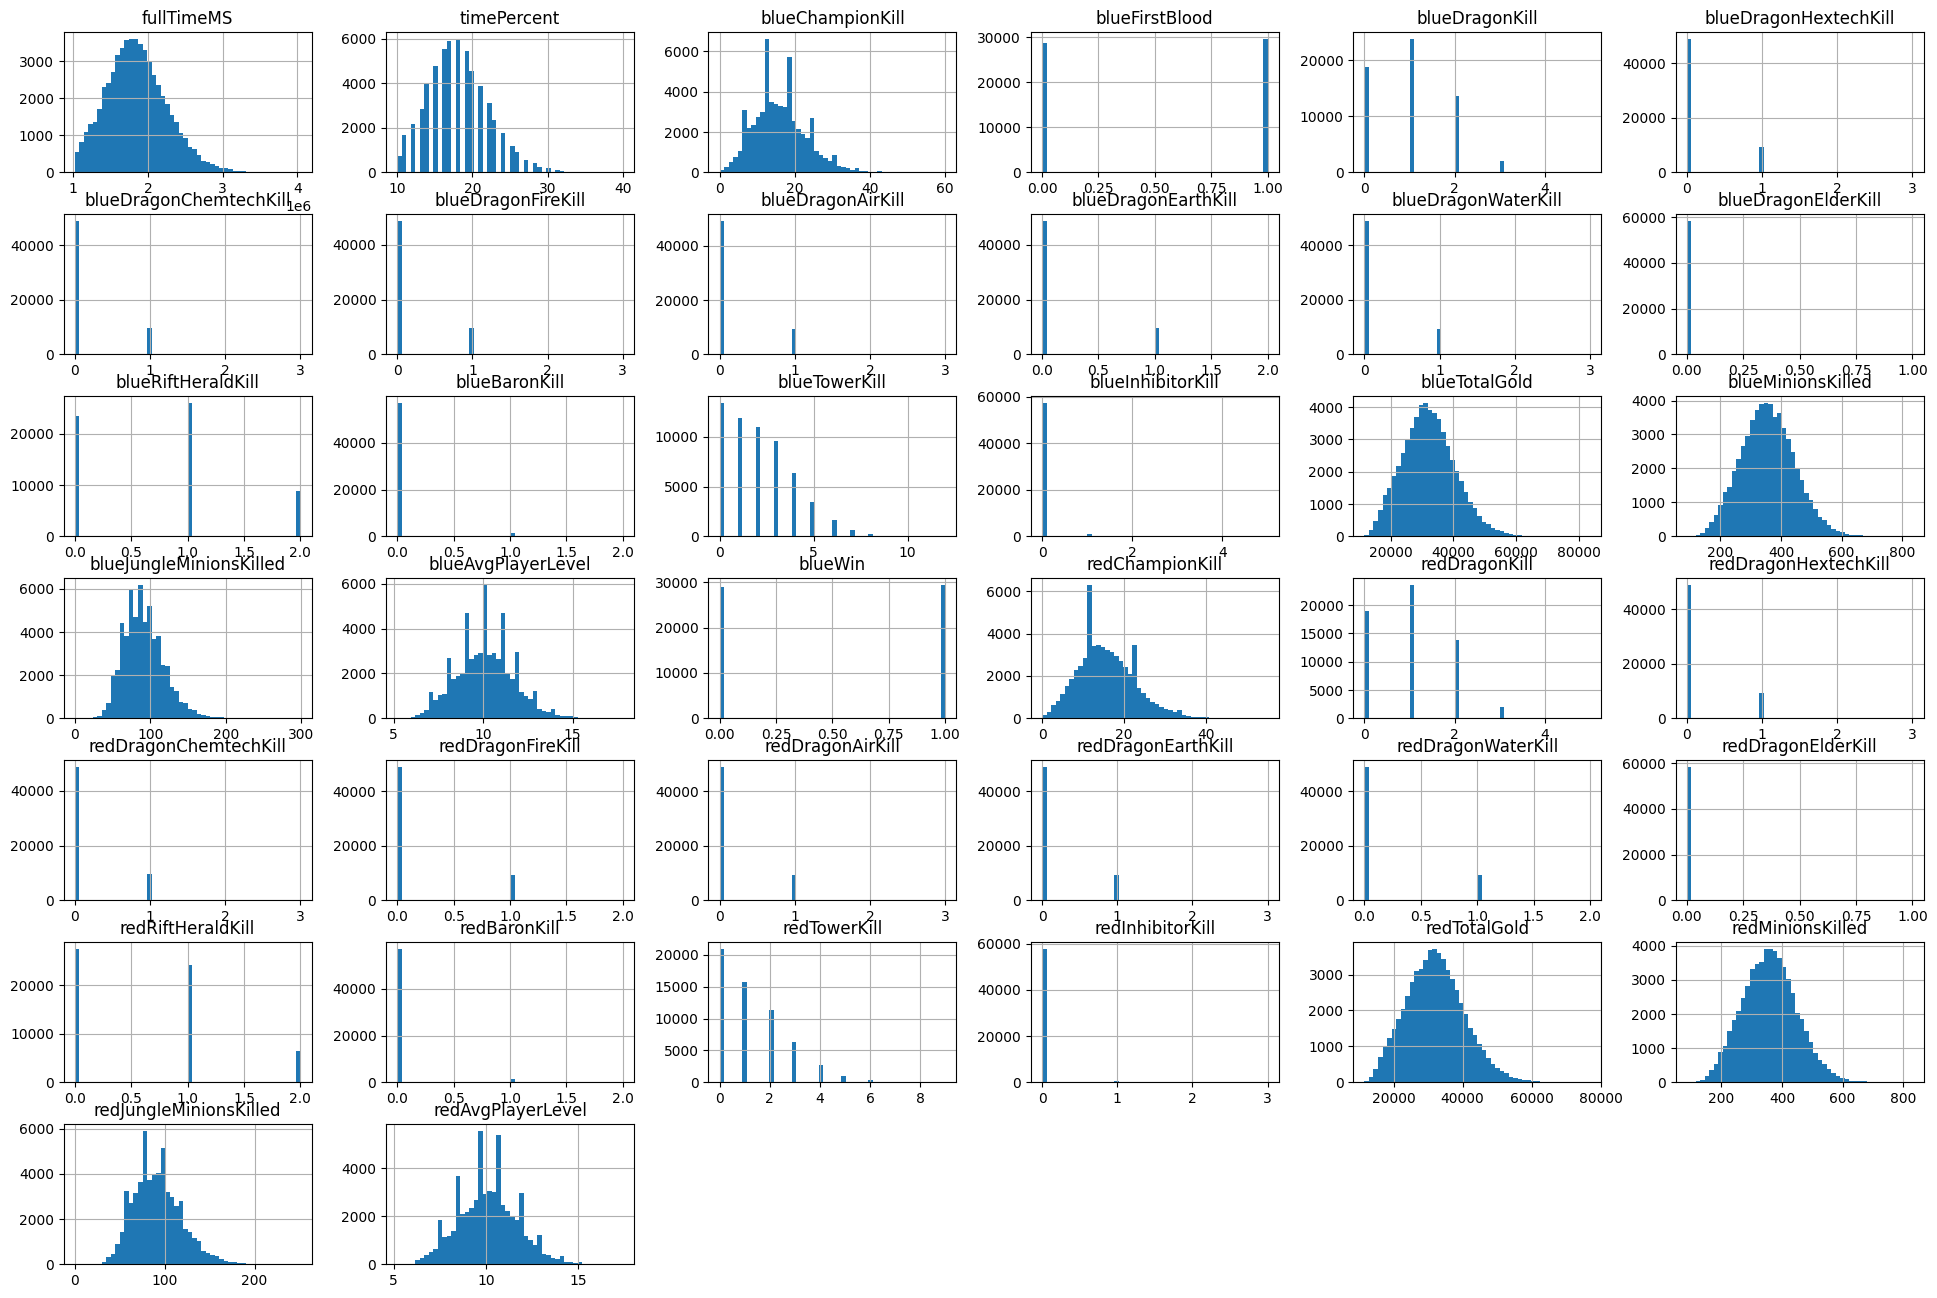

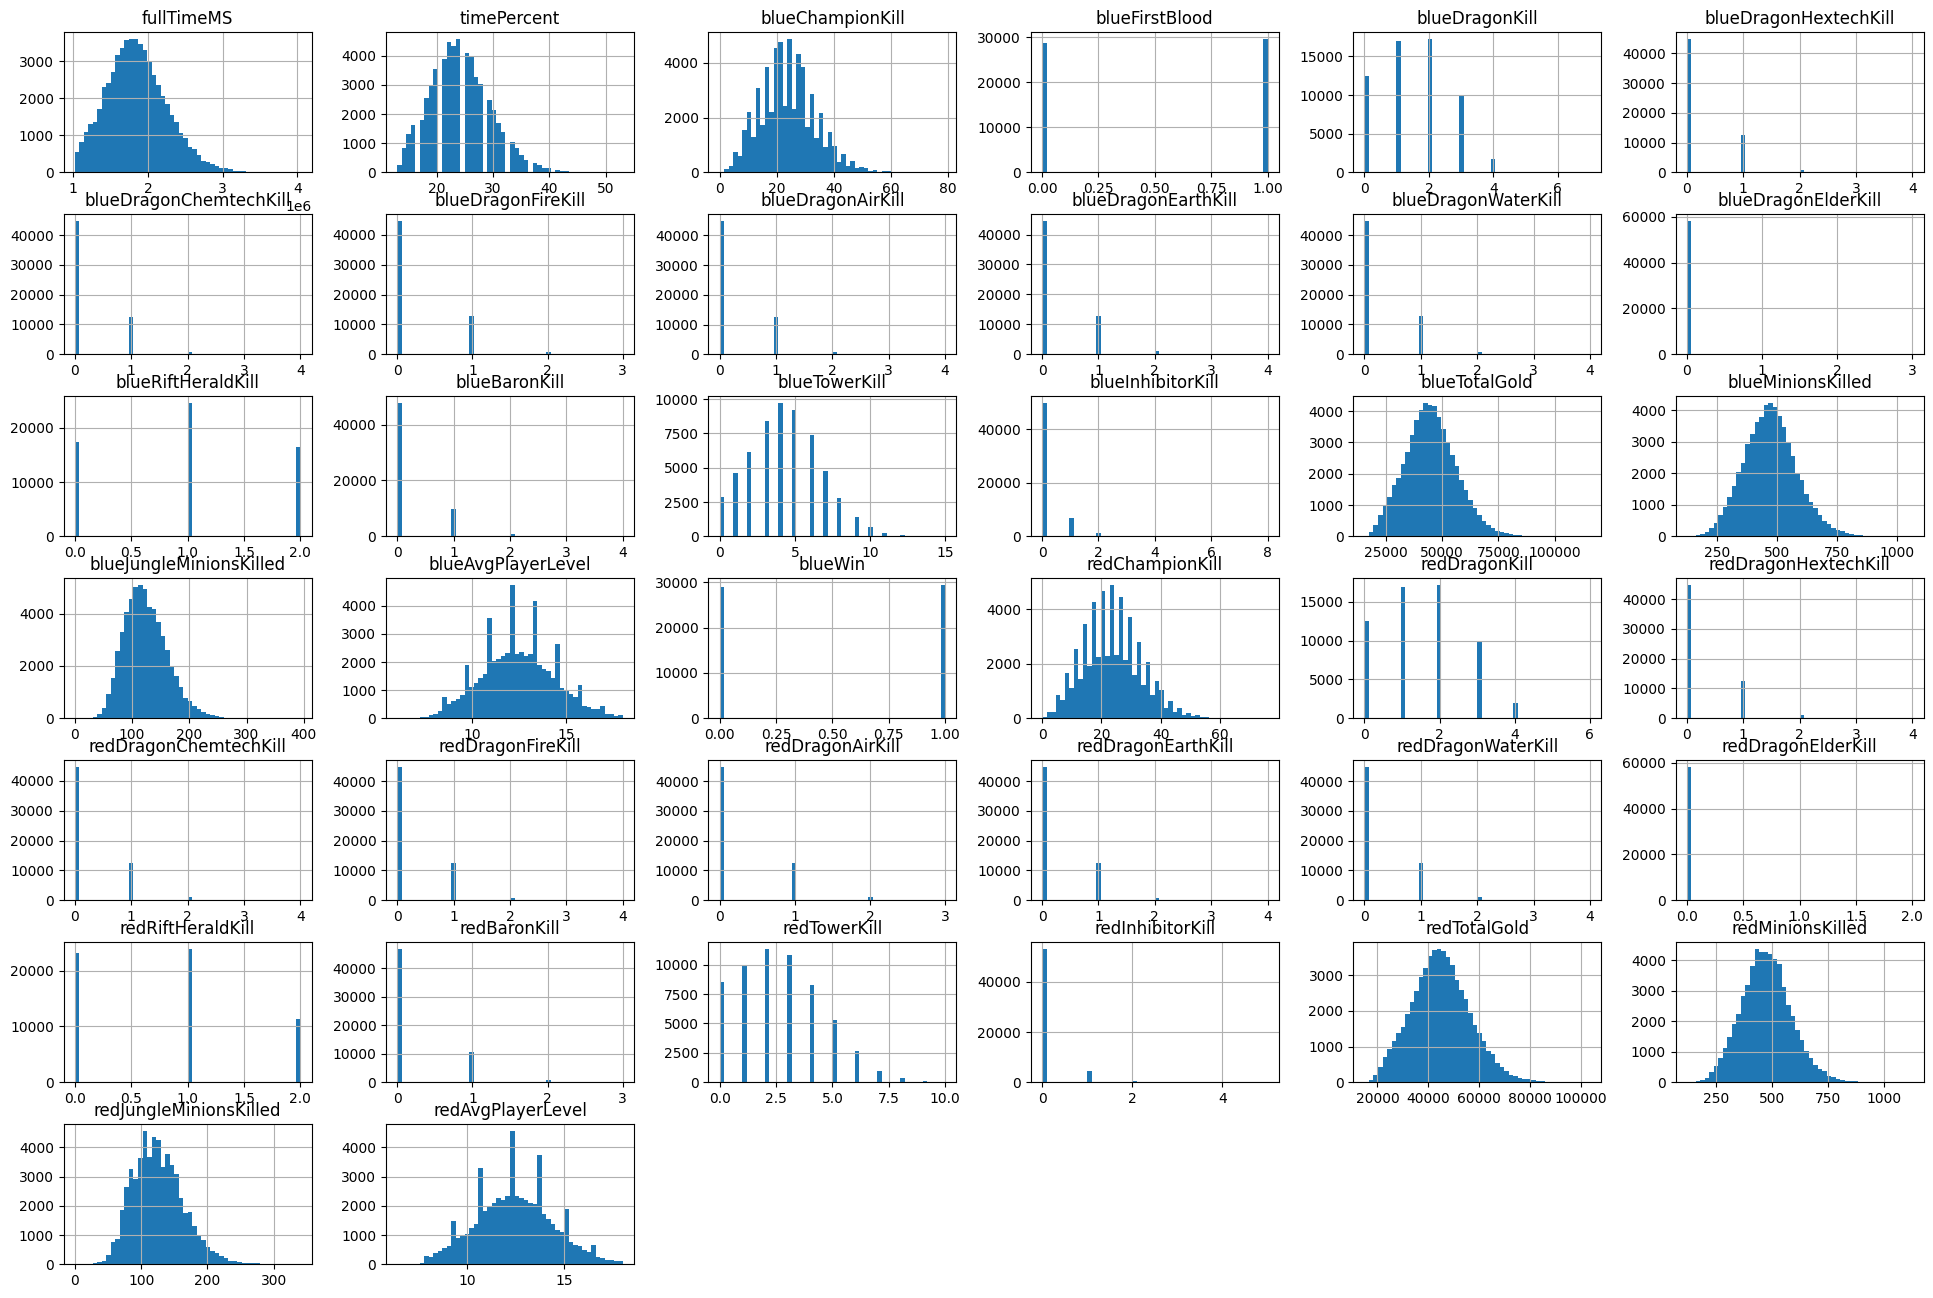

In [20]:
gamesAt20.hist(bins = 50 , figsize=(24 , 16))
plt.show()

gamesAt60.hist(bins = 50 , figsize=(24 , 16))
plt.show()

gamesAt80.hist(bins = 50 , figsize=(24 , 16))
plt.show()

##### Correlations

We should note that __in general__ when the correlation is negative it just means that the absolute value of that negative corelation would be the corelation for the feature redWin (which has been removed since it is just the opposite of blueWin).

In [21]:
corr_matrix2 = gamesAt20.corr(numeric_only=True)
corr_matrix6 = gamesAt60.corr(numeric_only=True)
corr_matrix8 = gamesAt80.corr(numeric_only=True)

In [22]:
corr_matrix2['blueWin'].reindex(gamesAt20.columns.tolist())

fullTimeMS                -0.011774
timePercent               -0.011214
blueChampionKill           0.105451
blueFirstBlood             0.133817
blueDragonKill             0.015183
blueDragonHextechKill      0.003662
blueDragonChemtechKill     0.007767
blueDragonFireKill         0.001223
blueDragonAirKill          0.003174
blueDragonEarthKill        0.018041
blueDragonWaterKill        0.003471
blueRiftHeraldKill        -0.002083
blueTotalGold              0.051790
blueMinionsKilled          0.028707
blueJungleMinionsKilled    0.032207
blueAvgPlayerLevel         0.017865
blueWin                    1.000000
redChampionKill           -0.117783
redDragonKill             -0.027200
redDragonHextechKill      -0.015304
redDragonChemtechKill     -0.012828
redDragonFireKill         -0.013398
redDragonAirKill          -0.012692
redDragonEarthKill        -0.004786
redDragonWaterKill        -0.006165
redRiftHeraldKill          0.005692
redTotalGold              -0.071630
redMinionsKilled          -0

Here we can see that almost all of the red team corelation are negative, which lines up with our expectations. We can also see that dragons and heralds have the least corelation, this also lines up with our expectations. Since this data is at only 20% of the game we cannot expect any useful information from these data points.

In [23]:
gamesAt20.drop(['blueDragonKill' , 'redDragonKill' , 'blueRiftHeraldKill' , 'redRiftHeraldKill' , 'blueDragonHextechKill' , 'redDragonHextechKill' , 'blueDragonChemtechKill' , 'redDragonChemtechKill' , 'blueDragonFireKill' , 'redDragonFireKill' , 'blueDragonAirKill' , 'redDragonAirKill' , 'blueDragonEarthKill' , 'redDragonEarthKill' , 'blueDragonWaterKill' , 'redDragonWaterKill'] , axis=1 , inplace=True)

At 60% game time here are the corelations

In [24]:
corr_matrix6['blueWin'].reindex(gamesAt60.columns.tolist())

fullTimeMS                -0.011774
timePercent               -0.012039
blueChampionKill           0.234387
blueFirstBlood             0.142891
blueDragonKill             0.300126
blueDragonHextechKill      0.117524
blueDragonChemtechKill     0.095990
blueDragonFireKill         0.110742
blueDragonAirKill          0.110314
blueDragonEarthKill        0.118853
blueDragonWaterKill        0.120675
blueDragonElderKill        0.002340
blueRiftHeraldKill         0.141460
blueBaronKill              0.013161
blueTowerKill              0.133477
blueInhibitorKill          0.022694
blueTotalGold              0.129371
blueMinionsKilled          0.084444
blueJungleMinionsKilled    0.116145
blueAvgPlayerLevel         0.076671
blueWin                    1.000000
redChampionKill           -0.247321
redDragonKill             -0.310567
redDragonHextechKill      -0.120016
redDragonChemtechKill     -0.094643
redDragonFireKill         -0.129904
redDragonAirKill          -0.115727
redDragonEarthKill        -0

80% game time

In [25]:
corr_matrix8['blueWin'].reindex(gamesAt80.columns.tolist())

fullTimeMS                -0.011774
timePercent               -0.011796
blueChampionKill           0.308809
blueFirstBlood             0.142891
blueDragonKill             0.448744
blueDragonHextechKill      0.172937
blueDragonChemtechKill     0.148410
blueDragonFireKill         0.171887
blueDragonAirKill          0.173789
blueDragonEarthKill        0.182384
blueDragonWaterKill        0.182258
blueDragonElderKill        0.001698
blueRiftHeraldKill         0.248350
blueBaronKill              0.148528
blueTowerKill              0.299169
blueInhibitorKill          0.092907
blueTotalGold              0.173772
blueMinionsKilled          0.082918
blueJungleMinionsKilled    0.223805
blueAvgPlayerLevel         0.123602
blueWin                    1.000000
redChampionKill           -0.322489
redDragonKill             -0.459984
redDragonHextechKill      -0.177769
redDragonChemtechKill     -0.152672
redDragonFireKill         -0.187735
redDragonAirKill          -0.177687
redDragonEarthKill        -0

#### Here is are the updated graphs

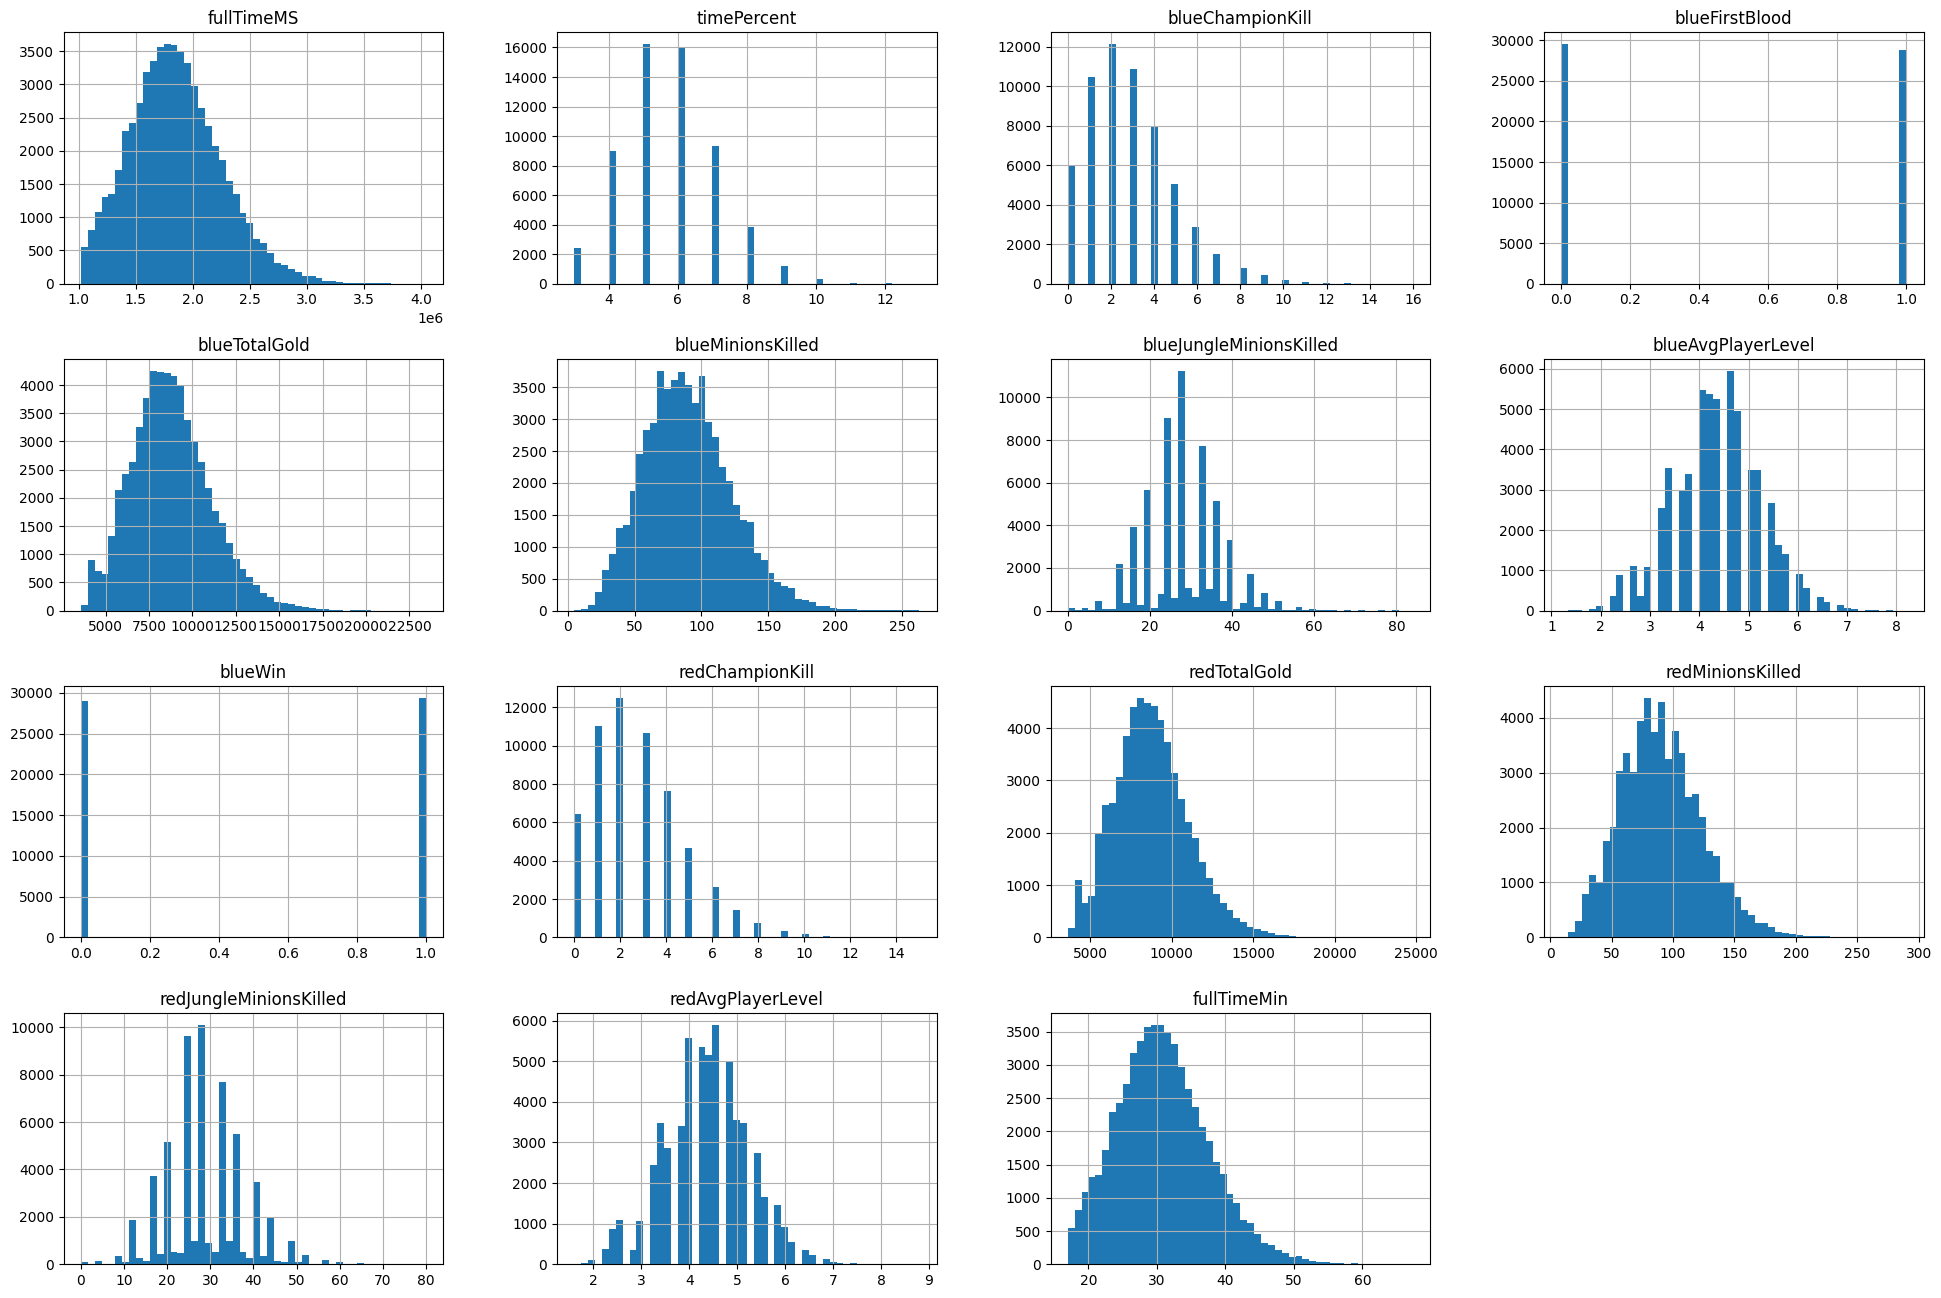

In [26]:
gamesAt20.hist(bins = 50 , figsize=(24 , 16))
plt.show()

gamesAt60.hist(bins = 50 , figsize=(24 , 16))
plt.show()

gamesAt80.hist(bins = 50 , figsize=(24 , 16))
plt.show()

#### Remove fullTimeMin and timePercent

These two features are for user reference only, fullTimeMin was used to determine a cutoff point and now that we are done with it we do not need it anymore.

In [27]:
# keeping the features for full game length decrease accuracy by ~10% for the 20% game time dataset

gamesAt20.drop(labels=['fullTimeMin'] , axis=1 , inplace=True)
#gamesAt60.drop(labels=['timePercent'] , axis=1 , inplace=True)
#gamesAt80.drop(labels=['timePercent'] , axis=1 , inplace=True)

# Part 3: Select and train a model

### Split the dataset into training and testing sets

In [28]:
from sklearn.model_selection import train_test_split

# 20% game time dataset
x = gamesAt20.drop(labels=['blueWin'] , axis=1)
y = gamesAt20['blueWin']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape , y_train.shape , x_test.shape , y_test.shape)

# 60% game time dataset
x60 = gamesAt60.drop(labels=['blueWin'] , axis=1)
y60 = gamesAt60['blueWin']

x_train60, x_test60, y_train60, y_test60 = train_test_split(x60, y60, test_size=0.2, random_state=42)
print(x_train60.shape , y_train60.shape , x_test60.shape , y_test60.shape)

# 80% game time dataset
x80 = gamesAt80.drop(labels=['blueWin'] , axis=1)
y80 = gamesAt80['blueWin']

x_train80, x_test80, y_train80, y_test80 = train_test_split(x80, y80, test_size=0.2, random_state=42)
print(x_train80.shape , y_train80.shape , x_test80.shape , y_test80.shape)

(46675, 13) (46675,) (11669, 13) (11669,)
(46675, 37) (46675,) (11669, 37) (11669,)
(46675, 37) (46675,) (11669, 37) (11669,)


## Classification

### Imports

In [29]:
from sklearn.svm import SVC , LinearSVC
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

### SVM Classifier - SVC - Default Hyperparameters

#### 20%

In [30]:
reg_svc = SVC()
reg_svc.fit(x_train , y_train)

SVC()

In [31]:

reg_y_pred = reg_svc.predict(x_test)
print(classification_report(y_test , reg_y_pred , digits=4))

              precision    recall  f1-score   support

           0       0.50      0.56      0.53      5725
           1       0.52      0.45      0.48      5944

    accuracy                           0.51     11669
   macro avg       0.51      0.51      0.51     11669
weighted avg       0.51      0.51      0.50     11669



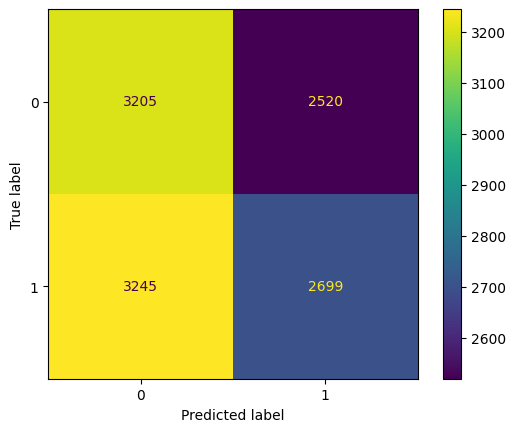

In [32]:
ConfusionMatrixDisplay.from_predictions(y_test , reg_y_pred)
plt.show()

#### 60%

In [33]:
reg_svc_60 = SVC()
reg_svc_60.fit(x_train60 , y_train60)

SVC()

In [34]:
reg_y_pred_60 = reg_svc_60.predict(x_test60)
print(classification_report(y_test60 , reg_y_pred_60 , digits=4))

              precision    recall  f1-score   support

           0       0.53      0.62      0.57      5725
           1       0.57      0.48      0.52      5944

    accuracy                           0.55     11669
   macro avg       0.55      0.55      0.55     11669
weighted avg       0.55      0.55      0.55     11669



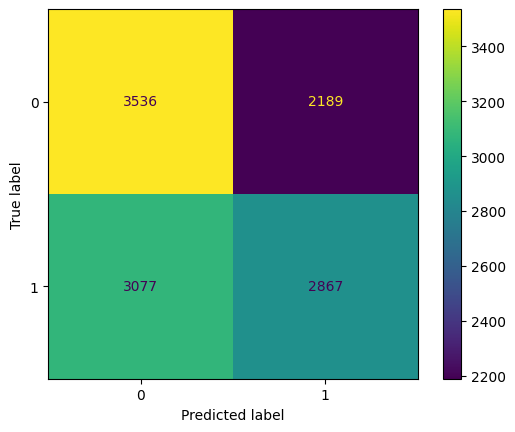

In [35]:
ConfusionMatrixDisplay.from_predictions(y_test60 , reg_y_pred_60)
plt.show()

#### 80%

In [36]:
reg_svc_80 = SVC()
reg_svc_80.fit(x_train80 , y_train80)

SVC()

In [37]:
reg_y_pred_80 = reg_svc_80.predict(x_test80)
print(classification_report(y_test80 , reg_y_pred_80 , digits=4))

              precision    recall  f1-score   support

           0       0.64      0.81      0.72      5725
           1       0.76      0.56      0.64      5944

    accuracy                           0.69     11669
   macro avg       0.70      0.69      0.68     11669
weighted avg       0.70      0.69      0.68     11669



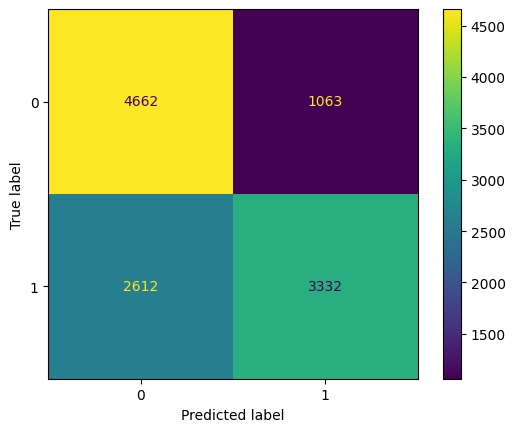

In [38]:
ConfusionMatrixDisplay.from_predictions(y_test80 , reg_y_pred_80)

### SVM Classifier rbf kernel (broken)

#### Train the model

rbf_svc = SVC(kernel='rbf' , C=1 , gamma=1)
rbf_svc.fit(x_train , y_train)

#### Test the model

rbf_y_pred = rbf_svc.predict(x_test)
print(classification_report(y_test , rbf_y_pred))

#### Performance Metrics

ConfusionMatrixDisplay.from_predictions(y_test , rbf_y_pred)
plt.show()

### Polynomial Kernel

#### 20%

In [39]:
poly_svc_kernel = make_pipeline(
    StandardScaler() , 
    SVC(kernel='poly' , degree=3 , C=1)
)
poly_svc_kernel.fit(x_train , y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, kernel='poly'))])

In [40]:
poly_svc_kernel_y_pred = poly_svc_kernel.predict(x_test)
print(classification_report(y_test , poly_svc_kernel_y_pred , digits=4))

              precision    recall  f1-score   support

           0       0.59      0.62      0.61      5725
           1       0.62      0.60      0.61      5944

    accuracy                           0.61     11669
   macro avg       0.61      0.61      0.61     11669
weighted avg       0.61      0.61      0.61     11669



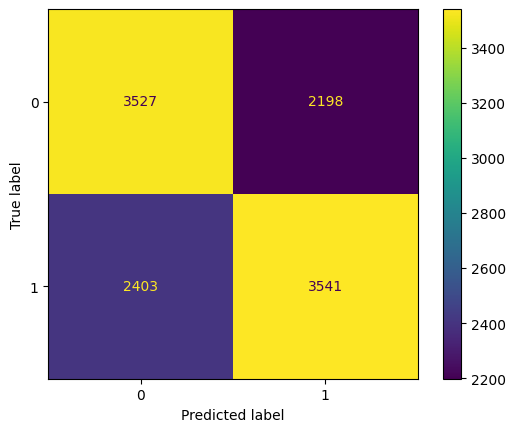

In [41]:
ConfusionMatrixDisplay.from_predictions(y_test , poly_svc_kernel_y_pred)
plt.show()

#### 60%

In [42]:
poly_svc_kernel_60 = make_pipeline(
    StandardScaler() , 
    SVC(kernel='poly' , degree=3 , C=1)
)
poly_svc_kernel_60.fit(x_train60 , y_train60)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, kernel='poly'))])

In [43]:
poly_svc_kernel_60_y_pred = poly_svc_kernel_60.predict(x_test60)
print(classification_report(y_test60 , poly_svc_kernel_60_y_pred , digits=4))

              precision    recall  f1-score   support

           0       0.74      0.75      0.75      5725
           1       0.76      0.75      0.76      5944

    accuracy                           0.75     11669
   macro avg       0.75      0.75      0.75     11669
weighted avg       0.75      0.75      0.75     11669



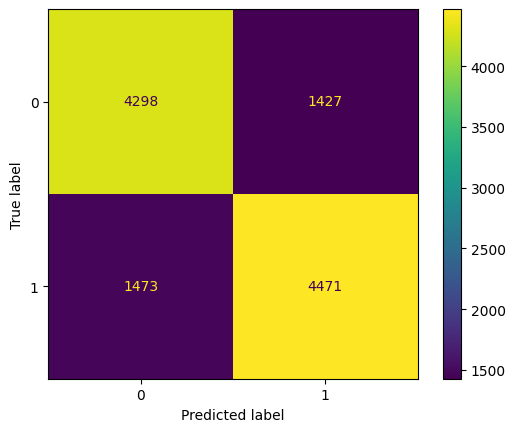

In [44]:
ConfusionMatrixDisplay.from_predictions(y_test60 , poly_svc_kernel_60_y_pred)
plt.show()

#### 80%

In [45]:
poly_svc_kernel_80 = make_pipeline(
    StandardScaler() , 
    SVC(kernel='poly' , degree=3 , C=1)
)
poly_svc_kernel_80.fit(x_train80 , y_train80)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, kernel='poly'))])

In [46]:
poly_svc_kernel_80_y_pred = poly_svc_kernel_80.predict(x_test80)
print(classification_report(y_test80 , poly_svc_kernel_80_y_pred , digits=4))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      5725
           1       0.85      0.85      0.85      5944

    accuracy                           0.84     11669
   macro avg       0.84      0.84      0.84     11669
weighted avg       0.84      0.84      0.84     11669



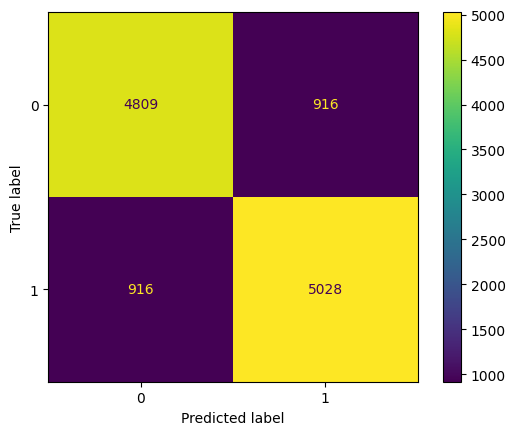

In [47]:
ConfusionMatrixDisplay.from_predictions(y_test80 , poly_svc_kernel_80_y_pred)
plt.show()

### Logistic Regression

#### 20%

In [48]:
log_reg_svm = make_pipeline(
    StandardScaler() , 
    LogisticRegression()
)
log_reg_svm.fit(x_train , y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [49]:
log_reg_y_pred = log_reg_svm.predict(x_test)
print(classification_report(y_test , log_reg_y_pred , digits=4))

              precision    recall  f1-score   support

           0       0.61      0.61      0.61      5725
           1       0.62      0.63      0.63      5944

    accuracy                           0.62     11669
   macro avg       0.62      0.62      0.62     11669
weighted avg       0.62      0.62      0.62     11669



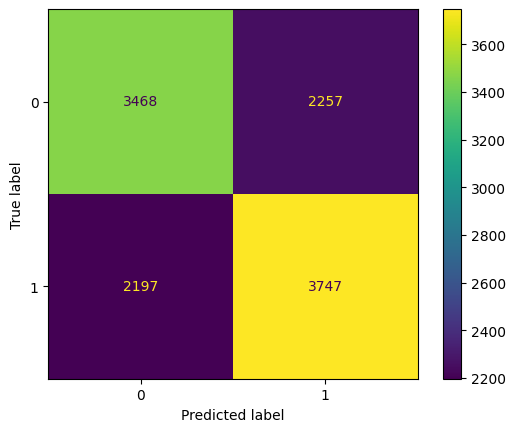

In [50]:
ConfusionMatrixDisplay.from_predictions(y_test , log_reg_y_pred)
plt.show()

#### 60%

In [51]:
log_reg_svm_60 = make_pipeline(
    StandardScaler() , 
    LogisticRegression()
)
log_reg_svm_60.fit(x_train60 , y_train60)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [52]:
log_reg_svm_60_y_pred = log_reg_svm_60.predict(x_test60)
print(classification_report(y_test60 , log_reg_svm_60_y_pred , digits=4))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      5725
           1       0.77      0.77      0.77      5944

    accuracy                           0.77     11669
   macro avg       0.77      0.77      0.77     11669
weighted avg       0.77      0.77      0.77     11669



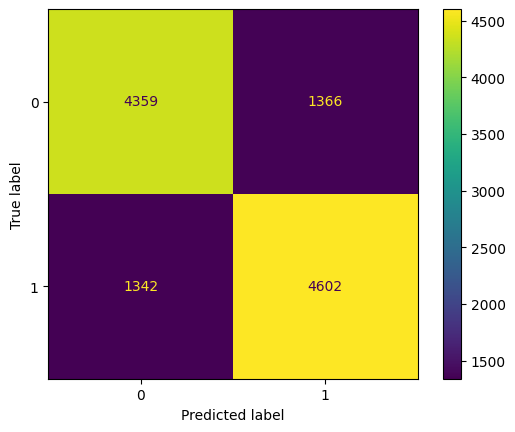

In [53]:
ConfusionMatrixDisplay.from_predictions(y_test60 , log_reg_svm_60_y_pred)
plt.show()

#### 80%

In [54]:
log_reg_svm_80 = make_pipeline(
    StandardScaler() , 
    LogisticRegression()
)
log_reg_svm_80.fit(x_train80 , y_train80)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [55]:
log_reg_svm_80_y_pred = log_reg_svm_80.predict(x_test80)
print(classification_report(y_test80 , log_reg_svm_80_y_pred , digits=4))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      5725
           1       0.85      0.85      0.85      5944

    accuracy                           0.85     11669
   macro avg       0.85      0.85      0.85     11669
weighted avg       0.85      0.85      0.85     11669



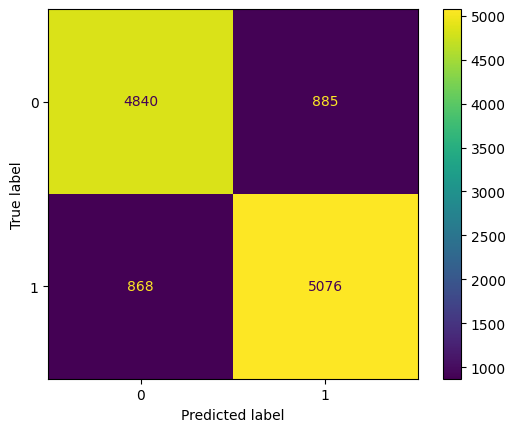

In [56]:
ConfusionMatrixDisplay.from_predictions(y_test80 , log_reg_svm_80_y_pred)
plt.show()

### LinearSVC

#### 20%

In [95]:
lin_svc = make_pipeline(
    StandardScaler() , 
    LinearSVC(C=10 , dual=False)
)
lin_svc.fit(x_train , y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=10, dual=False))])

In [96]:
lin_svc_y_pred = lin_svc.predict(x_test)
print(classification_report(y_test , lin_svc_y_pred , digits=4))

              precision    recall  f1-score   support

           0     0.6112    0.6054    0.6083      5725
           1     0.6234    0.6290    0.6262      5944

    accuracy                         0.6174     11669
   macro avg     0.6173    0.6172    0.6172     11669
weighted avg     0.6174    0.6174    0.6174     11669



[]

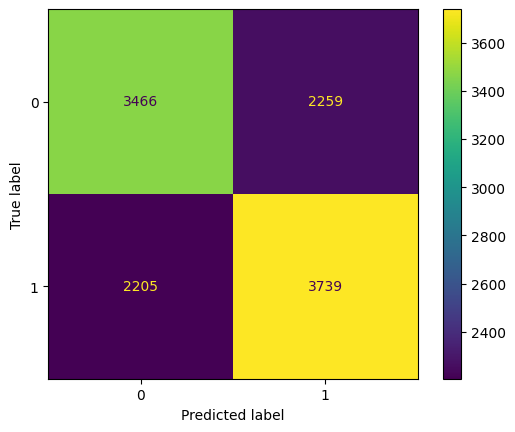

In [97]:
ConfusionMatrixDisplay.from_predictions(y_test , lin_svc_y_pred)
plt.plot()

#### 60%

In [98]:
lin_svc_60 = make_pipeline(
    StandardScaler() , 
    LinearSVC(C=10 , dual=False)
)
lin_svc_60.fit(x_train60 , y_train60)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=10, dual=False))])

In [99]:
lin_svc_60_y_pred = lin_svc_60.predict(x_test60)
print(classification_report(y_test60 , lin_svc_60_y_pred , digits=4))

              precision    recall  f1-score   support

           0     0.7646    0.7619    0.7633      5725
           1     0.7715    0.7741    0.7728      5944

    accuracy                         0.7681     11669
   macro avg     0.7680    0.7680    0.7680     11669
weighted avg     0.7681    0.7681    0.7681     11669



[]

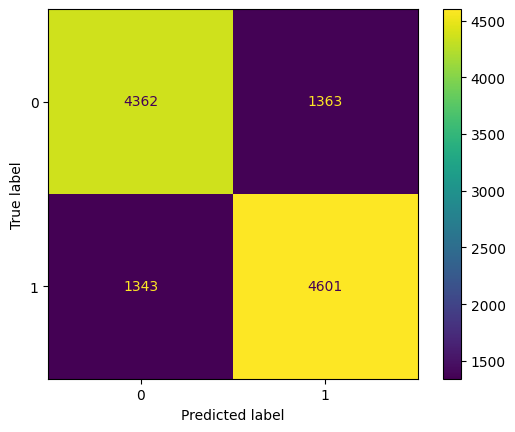

In [100]:
ConfusionMatrixDisplay.from_predictions(y_test60 , lin_svc_60_y_pred)
plt.plot()

#### 80%

In [101]:
lin_svc_80 = make_pipeline(
    StandardScaler() , 
    LinearSVC(C=10 , dual=False)
)
lin_svc_80.fit(x_train80 , y_train80)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=10, dual=False))])

In [102]:
lin_svc_80_y_pred = lin_svc_80.predict(x_test80)
print(classification_report(y_test80 , lin_svc_80_y_pred , digits=4))

              precision    recall  f1-score   support

           0     0.8479    0.8459    0.8469      5725
           1     0.8519    0.8538    0.8529      5944

    accuracy                         0.8499     11669
   macro avg     0.8499    0.8499    0.8499     11669
weighted avg     0.8499    0.8499    0.8499     11669



[]

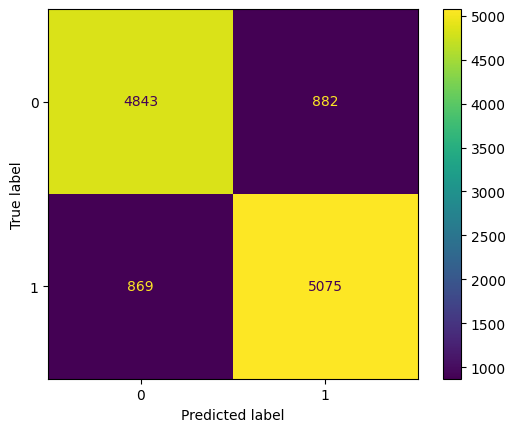

In [103]:
ConfusionMatrixDisplay.from_predictions(y_test80 , lin_svc_80_y_pred)
plt.plot()

## Optimization

Of the various models we have developed we will optimize the logistic regression and LinearSVC models using randomized search. We have chosen randomized search because it is faster than grid search, at the scale of our data it would take an absurdly long time to process. In the initial grid search test we allowed for grid search to make full use of the CPU, the search took over 30 minutes before we stopped it and it was unable to produce a result.

### Imports

In [104]:
from sklearn.model_selection import RandomizedSearchCV as RSCV

### Logistic Regression

#### 20%

In [110]:
para_dist_20 = {
    'C' : [0.001 , 0.01 , 0.1 , 1 , 10 , 100 , 1000] ,
    'max_iter' : [100 , 1000 , 10000 , 100000 , 1000000]
}

lin_svc_rscv_20 = LinearSVC(dual=False)

lin_svc_rscv_search = RSCV(lin_svc_rscv_20 , param_distributions=para_dist_20 , n_jobs=-1 , random_state=0)
lin_svc_rscv_search.fit(x_train , y_train)

svm_winner_20 = lin_svc_rscv_search.best_estimator_
print(svm_winner_20.score(x_test , y_test) , lin_svc_rscv_search.best_params_)


0.6189904876167623 {'max_iter': 100, 'C': 0.1}


#### 60%

In [111]:
para_dist_60 = {
    'C' : [0.001 , 0.01 , 0.1 , 1 , 10 , 100 , 1000] ,
    'max_iter' : [100 , 1000 , 10000 , 100000 , 1000000]
}

lin_svc_rscv_60 = LinearSVC(dual=False)

lin_svc_rscv_search_60 = RSCV(lin_svc_rscv_60 , param_distributions=para_dist_60 , n_jobs=-1 , random_state=0)
lin_svc_rscv_search_60.fit(x_train60 , y_train60)

svm_winner_60 = lin_svc_rscv_search_60.best_estimator_
print(svm_winner_60.score(x_test60 , y_test60) , lin_svc_rscv_search_60.best_params_)

0.7669894592510069 {'max_iter': 1000000, 'C': 100}


#### 80%

In [112]:
para_dist_80 = {
    'C' : [0.001 , 0.01 , 0.1 , 1 , 10 , 100 , 1000] ,
    'max_iter' : [100 , 1000 , 10000 , 100000 , 1000000]
}

lin_svc_rscv_80 = LinearSVC(dual=False)

lin_svc_rscv_search_80 = RSCV(lin_svc_rscv_80 , param_distributions=para_dist_80 , n_jobs=-1 , random_state=0)
lin_svc_rscv_search_80.fit(x_train80 , y_train80)

svm_winner_80 = lin_svc_rscv_search_80.best_estimator_
print(svm_winner_80.score(x_test80 , y_test80) , lin_svc_rscv_search_80.best_params_)

0.8484874453680692 {'max_iter': 1000, 'C': 1}
